In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

total_size = 0
num_files = len(os.listdir('/kaggle/input'))
pbar = tqdm(total=num_files)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Get the full path of the file
        file_path = os.path.join(dirname, filename)

        # Get the size of the file in bytes
        file_size = os.path.getsize(file_path)

        # Add the file size to the total size
        total_size += file_size
        pbar.update(1)
        
pbar.close()        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

3645it [00:02, 1331.78it/s]          


In [2]:
train_data = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

In [3]:
label_map = {"healthy":0, "multiple_diseases":1, "rust":2, "scab":3}
train_data['image_id'] = train_data['image_id'].apply(lambda x: x + ".jpg")
train_data['label'] = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
train_data['label_num'] = train_data['label'].map(label_map).astype(str)
train_data['healthy'] = train_data['healthy'].astype(str)
imageid_to_health = pd.DataFrame({
    'image_id': train_data['image_id'],
    'healthy': train_data['healthy']
}).sample(frac=1).reset_index(drop=True)

train_data_mc = pd.DataFrame({
    'image_id': train_data['image_id'],
    'label_num': train_data['label_num']
}).sample(frac=1).reset_index(drop=True)

images_directory = '/kaggle/input/plant-pathology-2020-fgvc7/images'

train_data_mc

,image_id,label_num
0,Train_780.jpg,3
1,Train_792.jpg,3
2,Train_168.jpg,3
3,Train_687.jpg,2
4,Train_1141.jpg,0
...,...,...
1816,Train_531.jpg,0
1817,Train_1426.jpg,0
1818,Train_937.jpg,0
1819,Train_207.jpg,3


In [4]:
def split_df(df, split_ratio):
    train_size = int(len(df) * split_ratio)
    train_df = df[:train_size]
    val_df = df[train_size:]
    return train_df, val_df

# train_imageid_to_health, val_imageid_to_health = split_df(imageid_to_health, .8)
train_mc, val_mc = split_df(train_data_mc, .8)

In [5]:
train_mc

,image_id,label_num
0,Train_780.jpg,3
1,Train_792.jpg,3
2,Train_168.jpg,3
3,Train_687.jpg,2
4,Train_1141.jpg,0
...,...,...
1451,Train_566.jpg,0
1452,Train_1288.jpg,3
1453,Train_1253.jpg,2
1454,Train_618.jpg,0


In [6]:
# shape_list = []
# for filename in os.listdir(png_directory):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Load the PNG image using PIL
#         img = Image.open(os.path.join(png_directory, filename))
#         shape_list.append(np.array(img).shape)

img = Image.open(os.path.join('/kaggle/input/plant-pathology-2020-fgvc7/images', 'Test_123.jpg'))
np.array(img).shape

(1365, 2048, 3)

In [7]:
def train_val_generators(train_df, val_df, images_directory, class_mode, y_cols):
    # Create an ImageDataGenerator object with data augmentation
    train_datagen = ImageDataGenerator(
        rescale = 1./255., 
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=.2,
        zoom_range=.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Use the flow_from_dataframe function to load the images
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=images_directory,
            x_col="image_id",
            y_col=y_cols,
            target_size=(170, 256),
            color_mode='rgb',
            batch_size=32,
            class_mode=class_mode
    )

    val_datagen = ImageDataGenerator(
        rescale = 1./255.
    )

    # Use the flow_from_dataframe function to load the images
    val_generator = train_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=images_directory,
            x_col="image_id",
            y_col=y_cols,
            target_size=(170, 256),
            color_mode='rgb',
            batch_size=32,
            class_mode=class_mode
    )
    
    return train_generator, val_generator
# train_plant_train_gen, val_plant_train_gen = train_val_generators(train_imageid_to_health, 
#                                                                   val_imageid_to_health, 
#                                                                   images_directory, 'binary', 
#                                                                   "healthy")
train_mc_gen, val_mc_gen = train_val_generators(train_mc, 
                                                val_mc, 
                                                images_directory, 
                                                'sparse', "label_num")

Found 1456 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


In [8]:
x_batch, y_batch = next(train_mc_gen)
# for poke in x_batch:
#     plt.imshow(poke)
#     plt.show()
#     break
x_batch.shape

(32, 170, 256, 3)

In [9]:
y_batch.shape

(32,)

In [10]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
# ### START CODE HERE       
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(170, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Not healthy') and 1 for the other ('Healthy')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [12]:
# callbacks = myCallback()
# # model = create_model()
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 2))

# rms_prop = RMSprop(learning_rate=1e-4)
# model.compile(optimizer = rms_prop,
#             loss = 'binary_crossentropy',
#             metrics=['accuracy'])

# history = model.fit(train_plant_train_gen,
#                     epochs=50,
#                     validation_data=val_plant_train_gen,
#                     callbacks=[callbacks])

In [20]:
### START CODE HERE       
model_mc = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(170, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Not healthy') and 1 for the other ('Healthy')
    tf.keras.layers.Dense(4, activation='softmax')  
])
callbacks_mc = myCallback()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 2))

rms_prop = RMSprop(learning_rate=1e-4)
# try adam
model_mc.compile(optimizer = 'rmsprop',
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

history_mc = model_mc.fit(train_mc_gen,
                    epochs=50,
                    validation_data=val_mc_gen)
#                     callbacks=[lr_schedule])

Epoch 1/50
46/46 [==============================] - 80s 2s/step - loss: 1.3175 - accuracy: 0.3201 - val_loss: 1.2401 - val_accuracy: 0.3397
Epoch 2/50
46/46 [==============================] - 77s 2s/step - loss: 1.2735 - accuracy: 0.3510 - val_loss: 1.2271 - val_accuracy: 0.3397
Epoch 3/50
46/46 [==============================] - 83s 2s/step - loss: 1.2541 - accuracy: 0.3262 - val_loss: 1.2216 - val_accuracy: 0.3397
Epoch 4/50
46/46 [==============================] - 77s 2s/step - loss: 1.2673 - accuracy: 0.3400 - val_loss: 1.2229 - val_accuracy: 0.4384
Epoch 5/50
46/46 [==============================] - 77s 2s/step - loss: 1.2359 - accuracy: 0.3695 - val_loss: 1.1669 - val_accuracy: 0.4740
Epoch 6/50
46/46 [==============================] - 77s 2s/step - loss: 1.2270 - accuracy: 0.3915 - val_loss: 1.2261 - val_accuracy: 0.3726
Epoch 7/50
46/46 [==============================] - 77s 2s/step - loss: 1.2261 - accuracy: 0.3771 - val_loss: 1.1843 - val_accuracy: 0.4000
Epoch 8/50
46/46 [==

(1e-05, 0.1, 0.0001, 20.0)

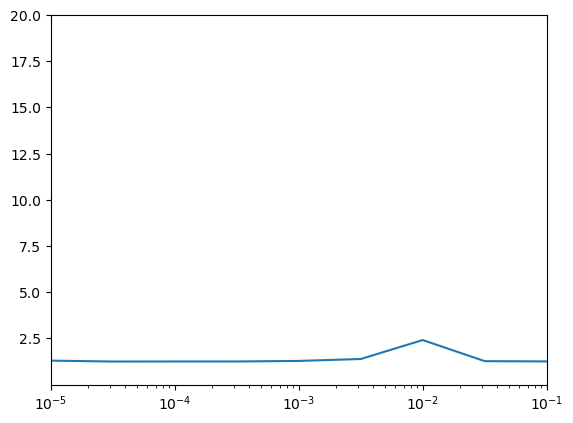

In [18]:
plt.semilogx(history_mc.history["lr"], history_mc.history["loss"])
plt.axis([1e-5, .1, 1e-4, 20])

<AxesSubplot:>

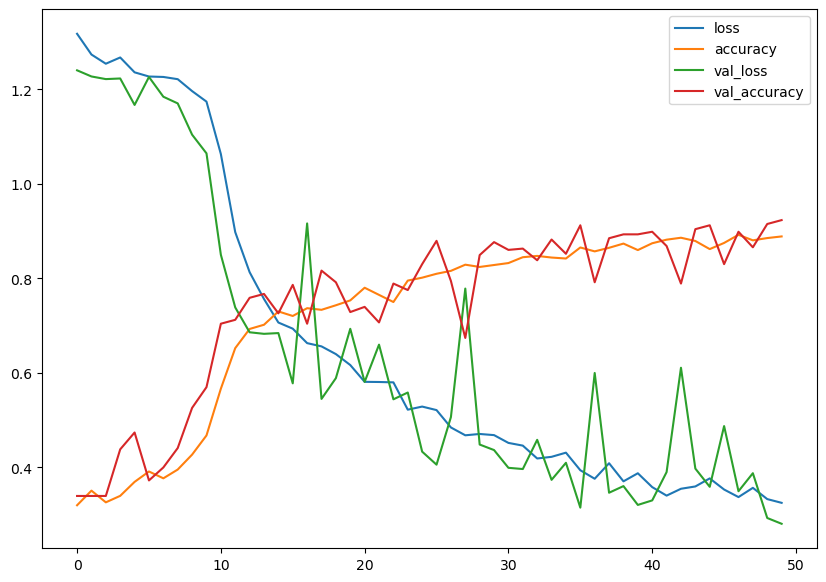

In [21]:
pd.DataFrame(history_mc.history).plot(figsize=(10, 7))